## Load data from influx and metaT samples

In [1]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
from scipy.stats import pearsonr
import plotnine as p9
import plotly.express as px
import os
import geopy.distance
import wget
# import pretty_plot()
# some_file.py
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/Users/Kathy/Desktop/UW/diel_workshop/')

from fig_tools import pretty_plot

# Data Preprocessing

In [2]:
# let's load 1 cruise fcm dataset for now- underway g3 and g3
g3 = pd.read_feather('/Users/Kathy/Desktop/UW/colocalization/gradients_individual/g3_FCM_distribution.feather')
ug3 = pd.read_feather('/Users/Kathy/Desktop/UW/colocalization/gradients_individual/ug3_FCM_distribution.feather')
# load ecotype dataand metadata
eco = pd.read_csv('/Users/Kathy/Desktop/UW/colocalization/gradients_pro_syn_relative_abundance.csv', 
                 usecols = ['SampleID','Genus','Clade','RelAbundance'])
eco_meta = pd.read_csv('/Users/Kathy/Desktop/UW/colocalization/sample_metadata.csv', 
                      usecols=['SampleID','Cruise','Station','Datetime','Latitude','Longitude','Depth',
                              'Replicate'])
# align data columns
eco_meta['Datetime'] = eco_meta['Datetime'].apply(lambda x: parse(x))
eco_meta['Cruise'] = eco_meta['Cruise'].str.upper()
# filter out data with no location data (inc experiments)
sub_eco_meta = eco_meta[(eco_meta['Latitude'].notnull()) & (eco_meta['Depth'].notnull())]
# merge with metadata
merged_eco = sub_eco_meta.merge(eco, how='left', on='SampleID')

In [3]:
# relative abundance is to the total number of cells in the sample (including pro/syn)
# calculate the total relative abundance to genus 
grouped = merged_eco.groupby(['SampleID','Genus'])
adj_eco = []
for s,new_df in grouped:
    sum_all = np.sum(new_df['RelAbundance'])
    new_df['RelAbundance_adj'] = new_df['RelAbundance']/sum_all
    # save into new dataframe
    adj_eco.append(new_df)
RA_eco = pd.concat(adj_eco).reset_index().drop(columns=['index'])

In [34]:
# only look at pro and syn for now
filt_g3=g3.loc[(g3['pop']=='prochloro') | (g3['pop']=='synecho')]
filt_ug3=ug3.loc[(ug3['pop']=='prochloro') | (ug3['pop']=='synecho')]
# filter by flags
filt_g3=filt_g3.loc[filt_g3['flag']==0]
filt_ug3=filt_ug3.loc[filt_ug3['flag']==0]
cols = ['date','lat','lon','depth','pop']
grouped_fcm = pd.concat([filt_g3.groupby(cols).mean().reset_index(),
                        filt_ug3.groupby(cols).mean().reset_index()])

## Let's visualize the data!
### Start with Depth Profiles of mean diameter across latitude

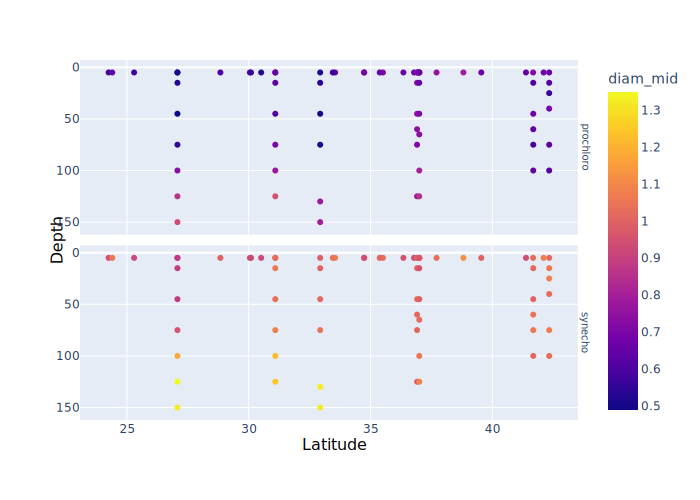

In [796]:
# plot the average size as a depth profile
fig = px.scatter(grouped_fcm, x='lat',y='depth', color=(grouped_fcm['diam_mid']), facet_row='pop')
fig['layout']['yaxis']['autorange'] = "reversed"
fig=pretty_plot(fig, y_label='Depth', x_label='Latitude')
fig.show('svg')
# pro gets bigger at higher latitudes and greater depths
# syn doesn't seem to change too much at the surface with latitude but increases with size 

In [6]:
# plot surface distributions 
pro_ug3=filt_ug3.loc[filt_ug3['pop']=='prochloro']
surface_pro=pd.concat([pro_ug3, filt_g3[(filt_g3['depth']==5)&(filt_g3['pop']=='prochloro')]])

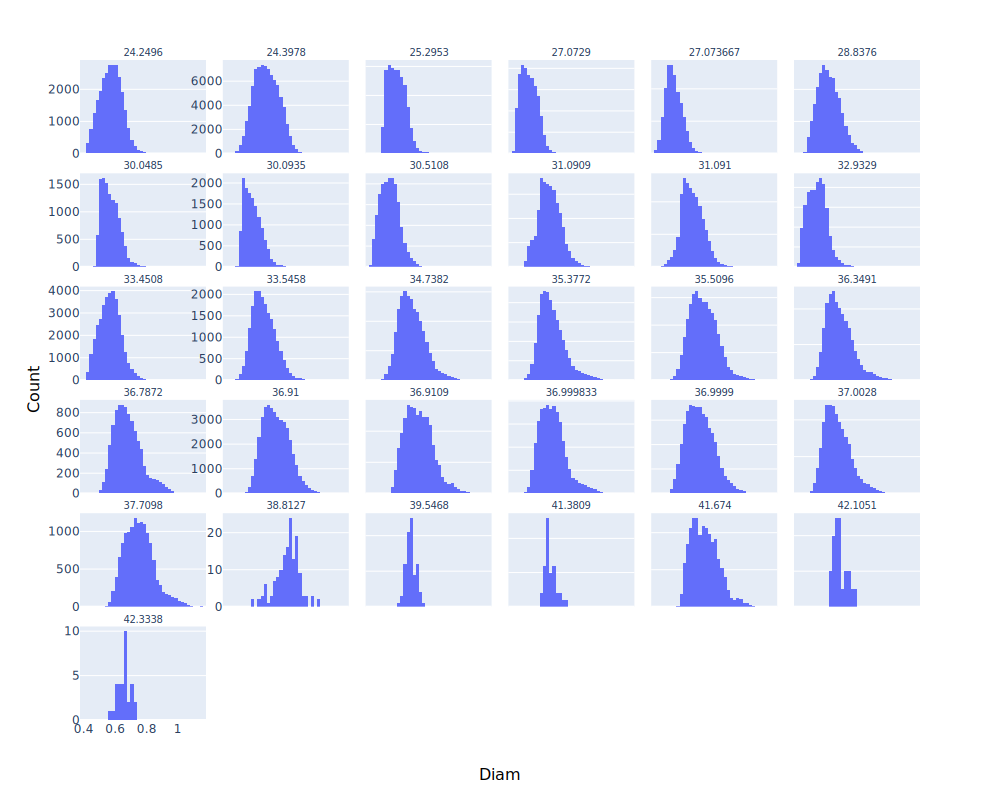

In [797]:
fig=px.histogram(surface_pro.sort_values(by=['lat','lon']), x='diam_mid', 
                 facet_col='lat',facet_col_wrap=6, facet_row_spacing=0.03, nbins=50,
                width=1000, height=800)
fig=pretty_plot(fig, rescale_y=True, x_label='Diam', y_label='Count')
fig.show('svg')

In [21]:
# grab g3 from metaT data
g3_eco = RA_eco[RA_eco['Cruise']=='KM1906']
# look at everything above 5% relative abundance to account for spurious mappings and ignore Not assigned
good_g3_eco = g3_eco.loc[(g3_eco['RelAbundance_adj'] >= 0.05)&
                         (g3_eco['Clade']!= "Not Assigned")]

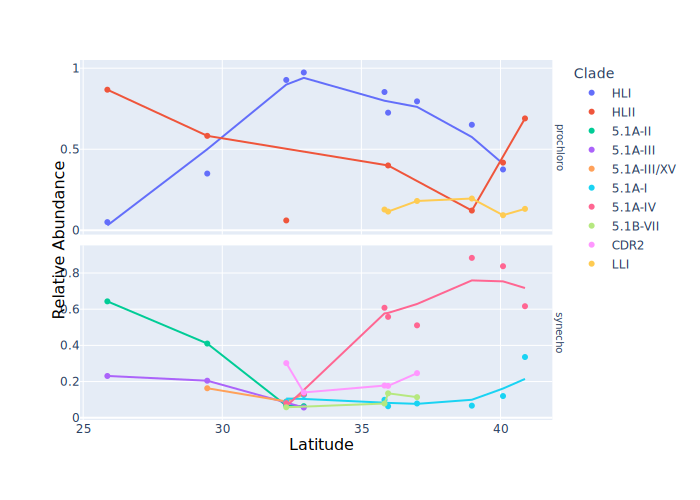

In [801]:
g3_eco=good_g3_eco[good_g3_eco['Depth']==7].groupby(['Datetime','Latitude','Longitude','Genus','Clade','Cruise']).agg({
    'RelAbundance_adj':'mean'
}).reset_index()
fig=px.scatter(g3_eco, x='Latitude',y='RelAbundance_adj',color='Clade', trendline='lowess', facet_row='Genus')
fig=pretty_plot(fig, rescale_y=True, y_label='Relative Abundance',x_label='Latitude')
fig.show('svg')

Pro HLI seems to increase until ~33º then decreases a bit. HLII decreases going north then shoots back up. LLI doesn't pop into the surface until 36, which makes sense at a high latitude. Also, it is in pretty low abundance compared to HL ecotypes, which also makes sense because it grows slower. 

5.1A0IV comes into the picture around 32º, right when 5.1A-II dies off. CDR2 briefly shows up in the mid latitude, while 5.1A-III is in lower latitudes around lower latitudes. 5.1A-I appears in low abundance at mid latitude and generally increases. 

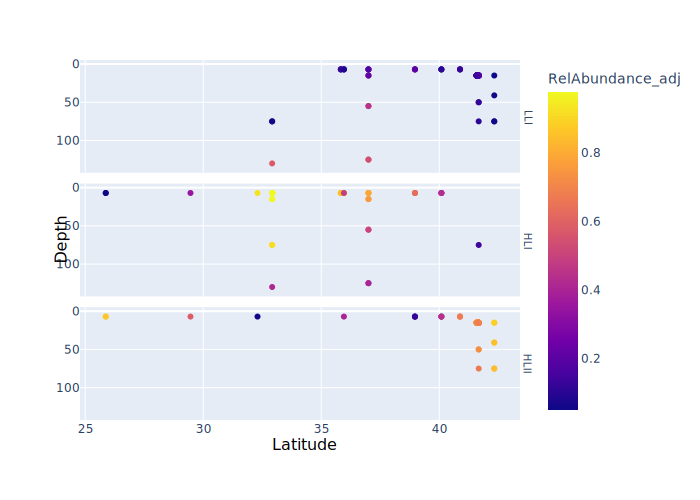

In [812]:
# look at relative abundace of ecotypes as a function of latitude and depth
fig=px.scatter(good_g3_eco.loc[good_g3_eco['Genus']=='prochloro'].sort_values(by=['Depth']), 
                 x='Latitude', y='Depth', color='RelAbundance_adj',facet_row='Clade')
fig['layout']['yaxis']['autorange'] = "reversed"
fig=pretty_plot(fig,y_label='Depth', x_label='Latitude')
fig.show('svg')

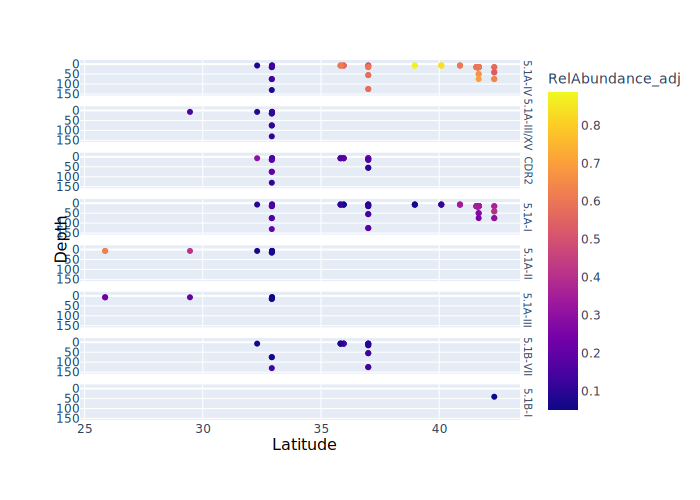

In [818]:
# look at relative abundace of ecotypes as a function of latitude and depth
fig = px.scatter(good_g3_eco.loc[good_g3_eco['Genus']=='synecho'].sort_values(by=['Depth']), 
                 x='Latitude', y='Depth', color='RelAbundance_adj',facet_row='Clade')
fig['layout']['yaxis']['autorange'] = "reversed"
fig=pretty_plot(fig,y_label='Depth', x_label='Latitude')
fig.show('svg')

## Match relative abundance from FCM and ecotype data as best as possible

In [280]:
# clean up ecotype data
good_eco = RA_eco.loc[(RA_eco['RelAbundance_adj'] >= 0.05)&
                         (RA_eco['Clade']!= "Not Assigned")]
# make sure all longitudes are negative
good_eco['Longitude']=-np.abs(good_eco['Longitude'])

/var/folders/x3/sy2cc75s04157vygzwcwbbzr0000gn/T/ipykernel_92450/3734427938.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [281]:
# fix ecotype data types
good_eco['Datetime'] = pd.DatetimeIndex(good_eco['Datetime']).tz_localize('UTC')
# match genus names in ecotype data for proper merge
good_eco.loc[good_eco['Genus']=='Prochlorococcus', 'Genus'] = 'prochloro'
good_eco.loc[good_eco['Genus']=='Synechococcus', 'Genus'] = 'synecho'

# take care of replicates in ecotype data
uniq_eco = good_eco.groupby(['Datetime','Latitude','Longitude','Depth','Genus','Clade']).agg({
    'RelAbundance_adj':'mean'
}).reset_index()
# round all depths to nearest 5
uniq_eco['round_depth'] = ((uniq_eco['Depth']//5)*5).astype(int)
# independet samples of ecotype data only
ind_eco = uniq_eco[['Datetime','Latitude','Longitude','Depth','round_depth']].drop_duplicates()

/var/folders/x3/sy2cc75s04157vygzwcwbbzr0000gn/T/ipykernel_92450/1087728099.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Kathy/anaconda3/envs/seaflow/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [282]:
influx_depths = pd.unique(grouped_fcm.sort_values(by=['depth'])['depth'])
eco_depths = pd.unique(ind_eco.sort_values(by=['Depth'])['Depth'])
print(f'Dephts for influx data: {influx_depths}')
print(f'Depths for ecotype data: {eco_depths}')
# combine all g3 data
all_g3 = pd.concat([filt_ug3, filt_g3])
all_g3['round_depth'] = ((all_g3['depth']//5)*5).astype(int)

Dephts for influx data: [  5  15  25  40  45  60  65  75 100 125 130 150]
Depths for ecotype data: [  7.  15.  41.  50.  55.  56.  75.  87.  95. 125. 130.]


In [283]:
# adjust time types to be consistent 
all_g3['date'] = pd.DatetimeIndex(all_g3['date']).tz_localize('UTC')
# only merge on influx metadata -> get full distributions after merge
g3_influx_meta = all_g3[['lat','lon','date','round_depth']].drop_duplicates()
# first check that all the points are within the same 2 days
time_merge = pd.merge_asof(
    ind_eco.sort_values(by="Datetime"), g3_influx_meta.sort_values(by="date"), 
    left_on="Datetime", right_on='date', 
    left_by=["round_depth"], right_by=['round_depth'],
    tolerance=pd.Timedelta(48, "hour"), direction='nearest')
# filter out inner merge by lat
time_merge = time_merge[time_merge['lat'].notnull()]

In [284]:
# are the points at least 10 km
def calc_distance(row):
    eco = (row['Latitude'], row['Longitude'])
    influx = (row['lat'], row['lon'])
    d = geopy.distance.distance(eco, influx).km
    return(d)

time_merge['distance'] = time_merge.apply(calc_distance, axis=1)
# get samples within 10 km of each other
dist_merge = time_merge[time_merge['distance'] < 5].reset_index()
dist_merge = dist_merge.drop(columns='index')
# add column to alos show time difference between samples
dist_merge['time_diff']=np.abs((dist_merge['Datetime'] - dist_merge['date']).astype('timedelta64[h]'))

In [285]:
# sort by distance and timethen only keep unique samples (no duplicates from influx)
all_g3_uniq_samp=dist_merge.sort_values(by=['distance', 
                           'time_diff']).drop_duplicates(subset=['date',
                                                                 'round_depth'], keep='first')
# there are only 11 samples that merged with g3 :/

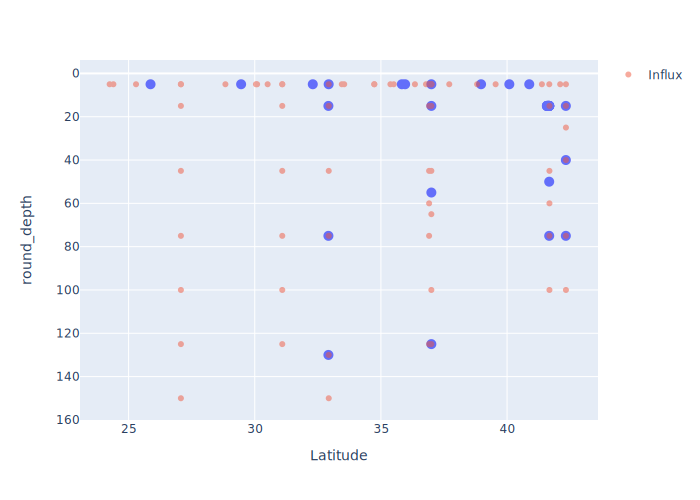

In [819]:
# plot to check everything works
import plotly.graph_objects as go
fig=px.scatter(ind_eco[pd.DatetimeIndex(ind_eco['Datetime']).year == 2019], 
               x='Latitude', y='round_depth', hover_data=['Datetime'])
fig.update_traces(marker=dict(size=10))
fig.add_trace(
    go.Scatter(
        x=g3_influx_meta['lat'],
        y=g3_influx_meta['round_depth'],
        mode='markers',
        name='Influx',
        opacity=0.5,
        customdata=np.stack(g3_influx_meta['date']),
        hovertemplate='<br>depth: %{y}<br>date: %{customdata} ',
        showlegend=True)
)
fig['layout']['yaxis']['autorange'] = "reversed"
fig.show('svg')
# there are only 38 independent metaT samples!! it makes sense that only 11 samples actually merged

### Add G1 and G2 data in

In [200]:
g1 = pd.read_feather('/Users/Kathy/Desktop/UW/colocalization/gradients_individual/g1_FCM_distribution.feather')
g2 = pd.read_feather('/Users/Kathy/Desktop/UW/colocalization/gradients_individual/g2_FCM_distribution.feather')
# only look at pro and syn for now
filt_g1=g1.loc[(g1['pop']=='prochloro') | (g1['pop']=='synecho')]
filt_g2=g2.loc[(g2['pop']=='prochloro') | (g2['pop']=='synecho')]
# filter by flags
filt_g1=filt_g1.loc[filt_g1['flag']==0]
filt_g2=filt_g2.loc[filt_g2['flag']==0]

In [287]:
# combine all g1-2 data
all_g1_2 = pd.concat([filt_g1, filt_g2])
# fix depths
all_g1_2['round_depth'] = ((all_g1_2['depth']//5)*5).astype(int)
# adjust time types to be consistent 
all_g1_2['date'] = pd.DatetimeIndex(all_g1_2['date']).tz_localize('UTC')
# only merge on influx metadata -> get full distributions after merge
g1_2_influx_meta = all_g1_2[['lat','lon','date','round_depth']].drop_duplicates()

In [288]:
# first check that all the points are within the same 2 days
time_merge = pd.merge_asof(
    ind_eco.sort_values(by="Datetime"), g1_2_influx_meta.sort_values(by="date"), 
    left_on="Datetime", right_on='date', 
    left_by=["round_depth"], right_by=['round_depth'],
    tolerance=pd.Timedelta(48, "hour"), direction='nearest')
# filter out inner merge by lat
time_merge = time_merge[time_merge['lat'].notnull()]

In [289]:
# do a distance merge
time_merge['distance'] = time_merge.apply(calc_distance, axis=1)
# get samples within 10 km of each other
dist_merge = time_merge[time_merge['distance'] < 5].reset_index()
dist_merge = dist_merge.drop(columns='index')
# add column to alos show time difference between samples
dist_merge['time_diff']=np.abs((dist_merge['Datetime'] - dist_merge['date']).astype('timedelta64[h]'))

In [290]:
# sort by distance and timethen only keep unique samples (no duplicates from influx)
all_g1_2_uniq_samp = dist_merge.sort_values(by=['distance', 
                           'time_diff']).drop_duplicates(subset=['date',
                                                                 'round_depth'], keep='first')
# there are only 18 samples that merged with g1 and 2 (total of 29 unique samples)
# hopefully that is enough to cluster!!

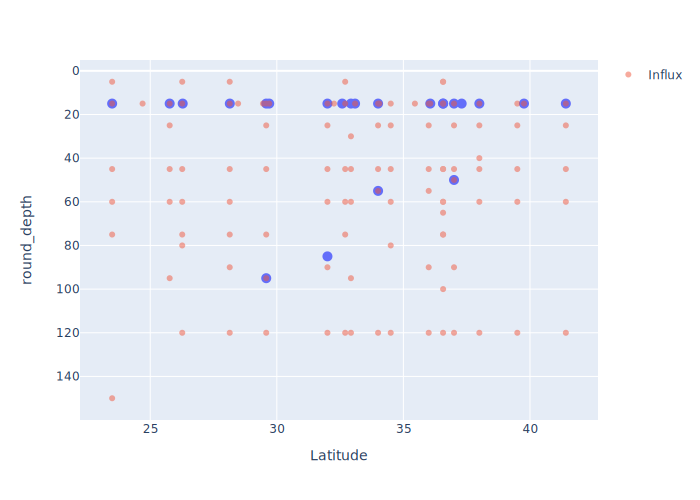

In [820]:
# plot to check everything works
import plotly.graph_objects as go
fig=px.scatter(ind_eco[pd.DatetimeIndex(ind_eco['Datetime']).year != 2019], 
               x='Latitude', y='round_depth', hover_data=['Datetime'])
fig.update_traces(marker=dict(size=10))
fig.add_trace(
    go.Scatter(
        x=g1_2_influx_meta['lat'],
        y=g1_2_influx_meta['round_depth'],
        mode='markers',
        name='Influx',
        opacity=0.5,
        customdata=np.stack(g1_2_influx_meta['date']),
        hovertemplate='<br>depth: %{y}<br>date: %{customdata} ',
        showlegend=True)
)
fig['layout']['yaxis']['autorange'] = "reversed"
fig.show('svg')

#### piece the dataset back together

In [394]:
# concat the metadata together
full_meta=pd.concat([all_g3_uniq_samp, all_g1_2_uniq_samp]).reset_index().drop(columns=['index'])
full_meta['id']=np.arange(0,len(full_meta))
eco_filter_cols=['Datetime','Latitude','Longitude','round_depth','id']
# merge the ecotype data out
all_eco_data=uniq_eco.merge(full_meta[eco_filter_cols], how='inner')
all_eco_data.rename(columns={'Genus':'pop'},inplace=True)
# merge the individual particle data out
keep_cols=['lat','lon','date','pop','norm.scatter','norm.red','norm.orange',
           'diam_mid','Qc_mid','round_depth','filename']
need_g1_2=all_g1_2[keep_cols]
need_g3=all_g3[keep_cols]
# stick g1-3 together
all_influx=pd.concat([need_g1_2, need_g3])
influx_filter_cols=['date','lat','lon','round_depth','id']
all_influx_data=all_influx.merge(full_meta[influx_filter_cols], how='inner')
# merge by the influx data
full_data_merge=all_influx_data.merge(all_eco_data,how='left')

# GMM Analysis
GMM tutorial [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html) <br>
[simple note on GMMs](https://www.ainesmile.com/machine-learning/2020/10/01/gaussian-mixture-models.html#mjx-eqn-weights) <br>
[intro with R](https://stephens999.github.io/fiveMinuteStats/intro_to_mixture_models.html)<br>
[Duke notes](https://users.cs.duke.edu/~cynthia/CourseNotes/GMMEMNotes.pdf)<br>
[towardsdatascience tutorial](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95)<br>
[kaggle](https://mathvault.ca/hub/higher-math/math-symbols/#Statistics-related_Operators)

In [444]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/Users/Kathy/Desktop/UW/diel_workshop/')

import fig_tools

In [403]:
drop_cols=['Datetime','Latitude','Longitude','Depth']
clean_data=full_data_merge.drop(columns=drop_cols)

#### Visaulize with 1 sample first

In [495]:
test1=clean_data[clean_data['id']==0]

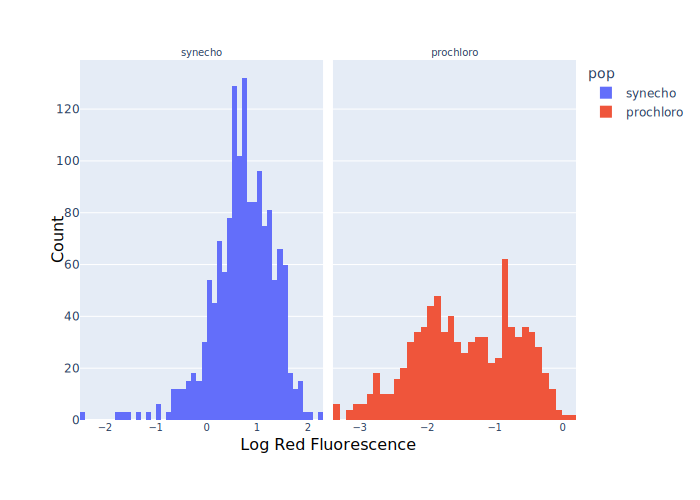

In [821]:
# test with 1 file first
fig=px.histogram(test1, x=np.log(test1['norm.red']),facet_col='pop', color='pop', 
             labels={'x':'Diameter', 'y':'count'},nbins=100)
fig=pretty_plot(fig,x_label='Log Red Fluorescence', y_label='Count',rescale_x=True)
fig.show('svg')

### Distinguishing mixture proportions

In [473]:
import matplotlib.pyplot as plt
import seaborn as sns

In [492]:
# fluoresence parameters are usually log-transformed in flow cytometry data
clean_data['log.norm.scatter']=np.log(clean_data['norm.scatter'])
clean_data['log.norm.red']=np.log(clean_data['norm.red'])
clean_data['log.norm.orange']=np.log(clean_data['norm.orange'])

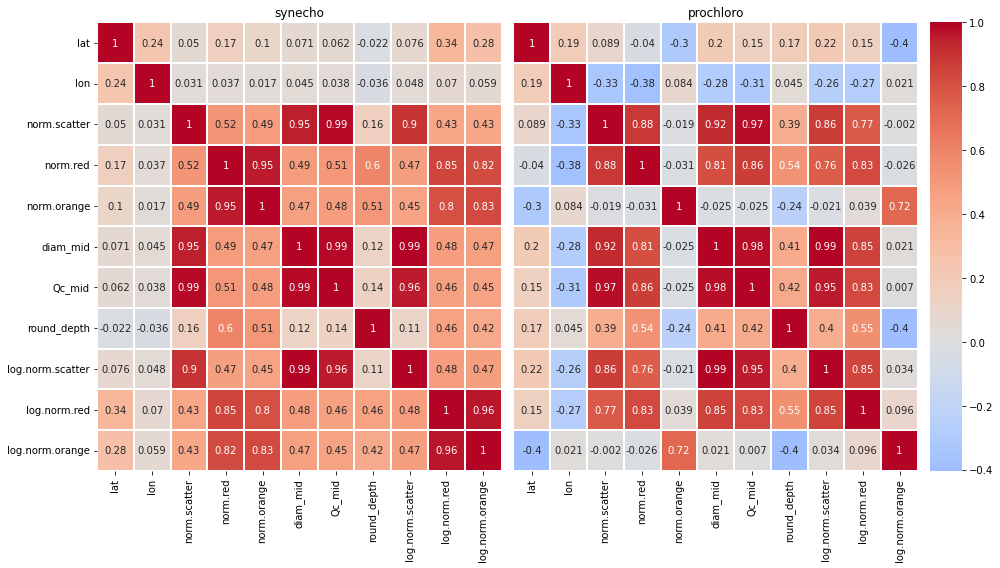

In [493]:
# let's first look at the features and if there are any correlations
features=['log.norm.scatter','log.norm.red','log.norm.orange','diam_mid','Qc_mid','round_depth','pop']
label=['Clade']
mix_prop=['RelAbundance_adj']

fig, ax = plt.subplots(1,3, gridspec_kw={'width_ratios':[1,1,0.08]}, figsize=(14,8))
ax[0].get_shared_y_axes().join(ax[0],ax[1])
count=0
for pop in pd.unique(clean_data['pop']):
    # subset df by class
    pop_df = clean_data.loc[clean_data['pop']==pop]
    corr_tbl = pop_df.drop(columns=['id','RelAbundance_adj']).corr().round(decimals=3)
    name = pop
    if (count==0):
        g=sns.heatmap(corr_tbl, cmap='coolwarm',center=0, linewidths=0.3,ax=ax[count], cbar=False, annot=True)
    else:
        g=sns.heatmap(corr_tbl, cmap='coolwarm',center=0, linewidths=0.3,ax=ax[count],cbar_ax=ax[2],annot=True)
        g.set_yticks([])
    ax[count].set_title(name)
    count+=1
plt.tight_layout()


THere is a lot of corelations between the fcm features themselves, some with chlorophyll and depth too for both Pro/Syn

In [640]:
# helper function to normalize and grab the relative abundances out per distribution in the gmm(clade)
def get_distributions(df):
    distributions=df.drop_duplicates(subset=['pop','Clade'])[['pop','Clade','RelAbundance_adj']]

    clades = distributions.groupby(['pop'])
    adj_eco = []
    for s,new_df in clades:
        sum_all = np.sum(new_df['RelAbundance_adj'])
        new_df['RelAbundance_norm'] = new_df['RelAbundance_adj']/sum_all
        # save into new dataframe
        adj_eco.append(new_df)
    norm_dist=pd.concat(adj_eco).reset_index().drop(columns=['index'])

    return(norm_dist)

In [722]:
import warnings
warnings.filterwarnings('ignore')

In [736]:
features=['log.norm.scatter','log.norm.red','log.norm.orange','diam_mid','Qc_mid','round_depth']
# save gmm results
pro_gmm=[]
syn_gmm=[]
# save distribution results
pro_dists=[]
syn_dists=[]

# for loop to go through each sample and fit gmm
for samp in pd.unique(clean_data['id']):
    # grab subset of data
    samp_df = clean_data.loc[clean_data['id']==samp]
    distributions=get_distributions(samp_df)
    # loop through each population per sample
    for pop in pd.unique(samp_df['pop']):
        pop_df=samp_df.loc[samp_df['pop']==pop]
        # drop any duplicates
        pop_df=pop_df.drop_duplicates(subset=features)
        # initalize model with weights (the relative abundances)
        pop_dist=distributions.loc[distributions['pop']==pop]
        pop_dist['id']=samp
        gmm = GaussianMixture(n_components=len(pop_dist), random_state=42, 
                      weights_init=pop_dist['RelAbundance_norm'].values)
        # fit data
        pop_data=pop_df[features].values.reshape(-1, pop_df[features].shape[1])
        gmm.fit(pop_data)
        # make predictions
        pop_df['target_class']=gmm.predict(pop_data)
        # save df based on populations
        if pop=='prochloro':
            pro_gmm.append(pop_df)
            pro_dists.append(pop_dist)
        else:
            syn_gmm.append(pop_df)
            syn_dists.append(pop_dist)
pro_gmm_df=pd.concat(pro_gmm)
syn_gmm_df=pd.concat(syn_gmm)

In [793]:
print(gmm.means_)
#print(gmm.covariances_)

[[-3.54498812 -1.28983616 -2.64034808  0.83055147  0.09311655 75.        ]
 [-2.02471208 -0.52234032 -1.96286565  1.17787026  0.22876195 75.        ]
 [-2.44838727 -0.79693058 -2.1804163   1.06459023  0.17618782 75.        ]
 [-1.47325954 -0.40821677 -1.86780841  1.35411851  0.33102839 75.        ]
 [-2.97627009 -1.00035795 -2.37152932  0.94264652  0.12884148 75.        ]]


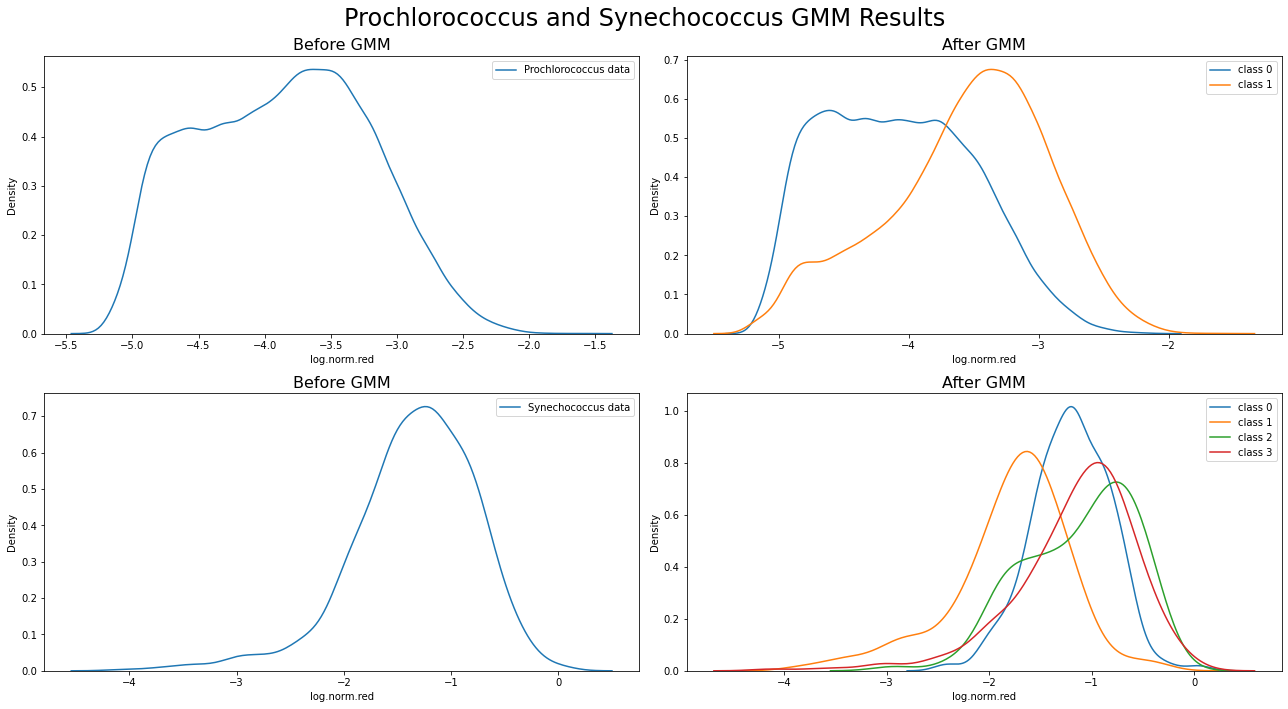

In [696]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
pro=pro_gmm[1].sort_values(by='target_class')
syn=syn_gmm[1].sort_values(by='target_class')
sns.kdeplot(data=pro['log.norm.red'], ax=ax[0][0],label='Prochlorococcus data')
# plot pro
f.suptitle('Prochlorococcus and Synechococcus GMM Results', fontsize=24)
ax[0][0].set_title('Before GMM', fontsize=16)
ax[0][0].legend()
for n in pd.unique(pro['target_class']):
    sns.kdeplot(data=pro[pro.target_class==n]['log.norm.red'], label=f'class {n}', ax=ax[0][1])
ax[0][1].set_title('After GMM', fontsize=16)
ax[0][1].legend()
# plot syn
sns.kdeplot(data=syn['log.norm.red'], ax=ax[1][0],label='Synechococcus data')
ax[1][0].set_title('Before GMM', fontsize=16)
ax[1][0].legend()
for n in pd.unique(syn['target_class']):
    sns.kdeplot(data=syn[syn.target_class==n]['log.norm.red'], label=f'class {n}', ax=ax[1][1])
ax[1][1].set_title('After GMM', fontsize=16)
ax[1][1].legend()
plt.tight_layout()

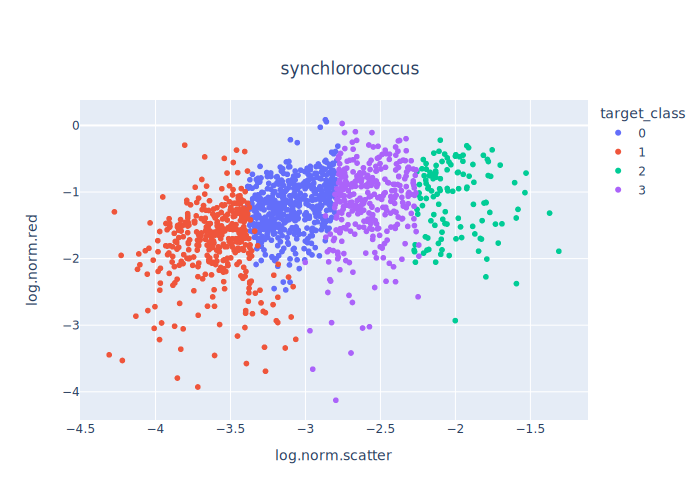

In [822]:
syn=syn.sort_values(by=['target_class'])
syn['target_class']=syn['target_class'].astype('O')
fig=px.scatter(syn, x='log.norm.scatter',y='log.norm.red',color='target_class',title='synchlorococcus')
fig.update_layout(title_x=0.5, title_y=0.875)
fig.show('svg')

In [720]:
# names of all possible clades
pro_clades=pd.unique(uniq_eco.loc[uniq_eco['Genus']=='prochloro', 'Clade'])
syn_clades=pd.unique(uniq_eco.loc[uniq_eco['Genus']=='synecho', 'Clade'])

In [726]:
pro_dists_df=pd.concat(pro_dists)
syn_dists_df=pd.concat(syn_dists)

In [791]:
HLI_samples=pro_dists_df.loc[pro_dists_df['Clade']=='HLI'].sort_values(by=['RelAbundance_norm'],
                                                                      ascending=False)

In [770]:
pro_dists_df.loc[pro_dists_df['id']==7]

,pop,Clade,RelAbundance_adj,RelAbundance_norm,id
0,prochloro,HLI,0.411055,0.416399,7
1,prochloro,LLI,0.576111,0.583601,7


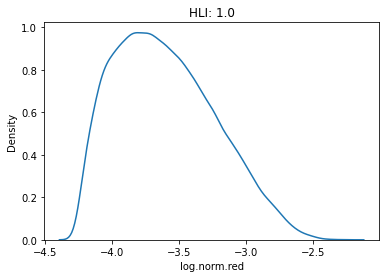

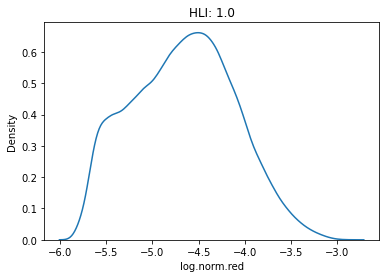

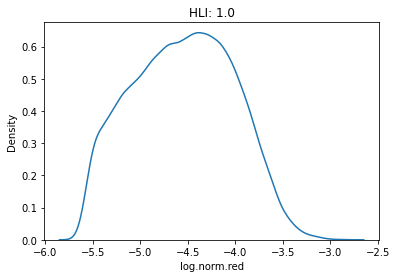

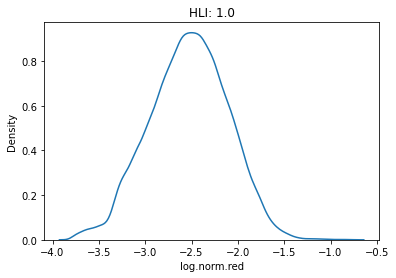

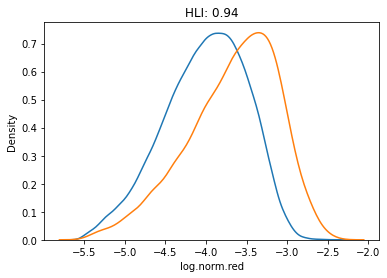

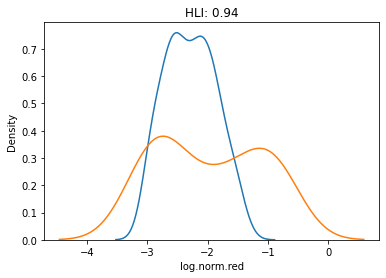

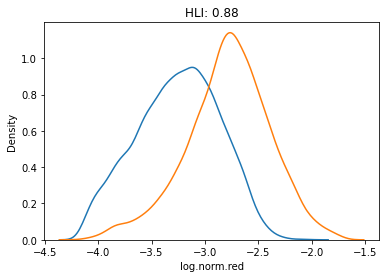

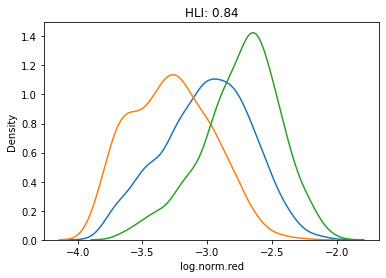

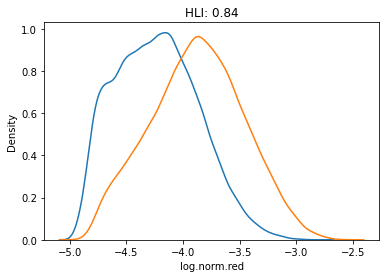

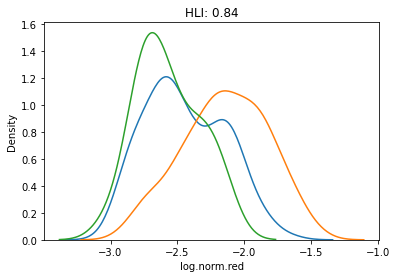

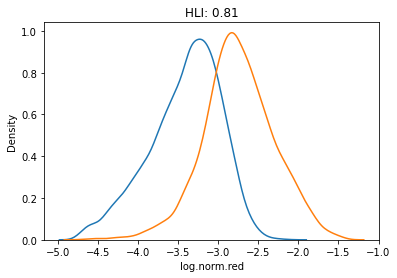

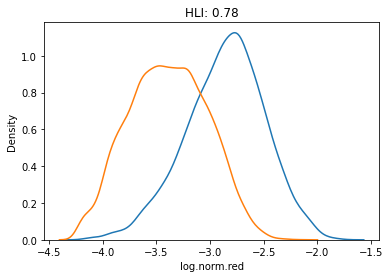

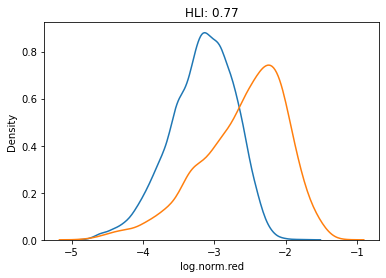

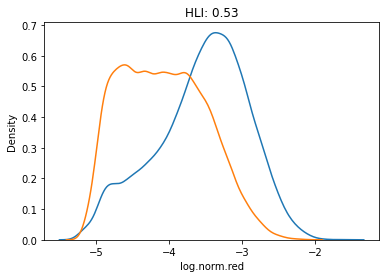

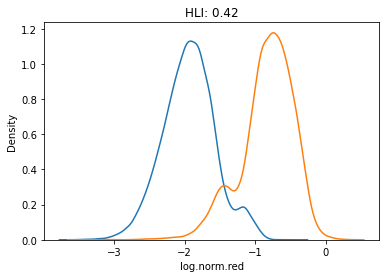

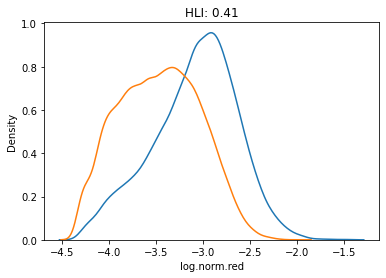

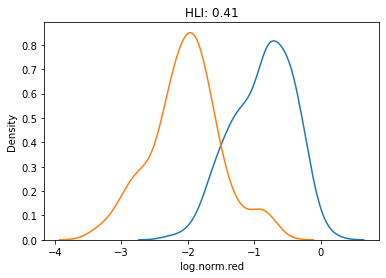

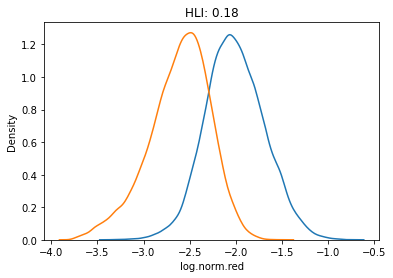

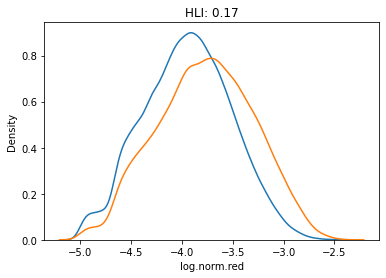

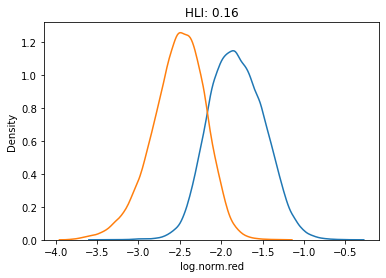

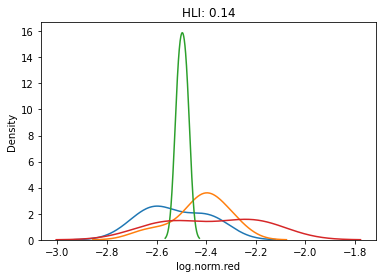

In [769]:
for samp in HLI_samples['id']:
    samp_df=pro_gmm_df.loc[pro_gmm_df['id']==samp]
    # make a plot
    fig, ax=plt.subplots(1,1)
    for n in pd.unique(samp_df['target_class']):
        sns.kdeplot(data=samp_df[samp_df.target_class==n]['log.norm.red'], label=f'class {n}',ax=ax)
    HLI_ratio=np.round(HLI_samples.loc[HLI_samples.id==samp].RelAbundance_norm[0], 2)
    ax.set_title(f'HLI: {HLI_ratio}')